# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.scaler.force import EnergyForceExtensiveScaler
scaler = EnergyForceExtensiveScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
_, eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "module_name": "kgcnn.literature.Schnet", 
    "class_name":"make_model", 
    "output_as_dict":True,
    "config":{
        "name": "Schnet",
        "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                   {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                   {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
        "make_distance": True, "expand_distance": True,
        "interaction_args": {"units": 128, "use_bias": True,
                             "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
        "node_pooling_args": {"pooling_method": "sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
        "verbose": 10,
        "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                     "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
        "output_embedding": "graph", "output_to_tensor": True,
        "use_output_mlp": True,
        "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                       "activation": ["kgcnn>shifted_softplus", "linear"]}},
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model.model_config["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 4s 27ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 18.9761 - energy_loss: 0.2477 - force_loss: 0.9364 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9252 - energy_loss: 0.2060 - force_loss: 0.9360 - 537ms/epoch - 67ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9000 - energy_loss: 0.2068 - force_loss: 0.9347 - 538ms/epoch - 67ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8038 - energy_loss: 0.2470 - force_loss: 0.9278 - 529ms/epoch - 66ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.5556 - energy_loss: 0.3225 - force_loss: 0.9117 - 526ms/epoch - 66ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.0966 - energy_loss: 0.4374 - force_loss: 0.8830 - 526ms/epoch - 66ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.3767 - energy_loss: 1.5190 - force_loss: 0.8429 - 525ms/epoch - 66ms/step
Epoch 8/1500
8/8 - 1s - loss: 18.8545 - energy_loss: 1.4466 - force_loss: 0.8704 - 524ms/epoch - 66ms/step
Epoch 9/1500
8/8 - 1s - loss: 18.2630 - energy_loss: 0.5420 - force_loss: 0.8860 - 530ms/epoch - 66ms/step
Epoch 10/1500
8/8 - 1s - loss: 17.4124 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.4269 - energy_loss: 0.8212 - force_loss: 0.2803 - 543ms/epoch - 68ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.4254 - energy_loss: 0.7999 - force_loss: 0.2813 - 549ms/epoch - 69ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.6880 - energy_loss: 0.7819 - force_loss: 0.2953 - 548ms/epoch - 68ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.6459 - energy_loss: 0.8232 - force_loss: 0.2911 - 525ms/epoch - 66ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.4237 - energy_loss: 0.7811 - force_loss: 0.2821 - 528ms/epoch - 66ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.3350 - energy_loss: 0.8025 - force_loss: 0.2766 - 525ms/epoch - 66ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.4698 - energy_loss: 0.9418 - force_loss: 0.2764 - 535ms/epoch - 67ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.1815 - energy_loss: 0.8268 - force_loss: 0.2677 - 525ms/epoch - 66ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.7214 - energy_loss: 1.4057 - force_loss: 0.2658 - 528ms/epoch - 66ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.5686

8/8 - 1s - loss: 3.9680 - energy_loss: 0.3396 - force_loss: 0.1814 - 527ms/epoch - 66ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.3673 - energy_loss: 0.7429 - force_loss: 0.1812 - 526ms/epoch - 66ms/step
Epoch 156/1500
8/8 - 1s - loss: 3.9178 - energy_loss: 0.3017 - force_loss: 0.1808 - 523ms/epoch - 65ms/step
Epoch 157/1500
8/8 - 1s - loss: 3.8261 - energy_loss: 0.2878 - force_loss: 0.1769 - 522ms/epoch - 65ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.7431 - energy_loss: 1.1700 - force_loss: 0.1787 - 521ms/epoch - 65ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.6762 - energy_loss: 1.0261 - force_loss: 0.1825 - 540ms/epoch - 68ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.8366 - energy_loss: 1.0755 - force_loss: 0.1881 - 544ms/epoch - 68ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.8279 - energy_loss: 1.0313 - force_loss: 0.1898 - 532ms/epoch - 67ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.7739 - energy_loss: 0.8919 - force_loss: 0.1941 - 550ms/epoch - 69ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.8822 - en

Epoch 230/1500
8/8 - 1s - loss: 3.8110 - energy_loss: 0.5482 - force_loss: 0.1631 - 522ms/epoch - 65ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.6635 - energy_loss: 0.5573 - force_loss: 0.1553 - 535ms/epoch - 67ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.5237 - energy_loss: 0.5211 - force_loss: 0.1501 - 530ms/epoch - 66ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.4632 - energy_loss: 0.5274 - force_loss: 0.1468 - 522ms/epoch - 65ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.5255 - energy_loss: 0.5460 - force_loss: 0.1490 - 524ms/epoch - 66ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.5146 - energy_loss: 0.5129 - force_loss: 0.1501 - 526ms/epoch - 66ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.4159 - energy_loss: 0.5231 - force_loss: 0.1446 - 523ms/epoch - 65ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.4113 - energy_loss: 0.5181 - force_loss: 0.1447 - 529ms/epoch - 66ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.3910 - energy_loss: 0.5136 - force_loss: 0.1439 - 525ms/epoch - 66ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.2860 - energy_loss: 0.4764 - force_loss: 0.1405 - 527ms/epoch - 66ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.3336 - energy_loss: 0.5104 - force_loss: 0.1412 - 530ms/epoch - 66ms/step
Epoch 308/1500
8/8 - 1s - loss: 3.2814 - energy_loss: 0.5078 - force_loss: 0.1387 - 527ms/epoch - 66ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.2515 - energy_loss: 0.5174 - force_loss: 0.1367 - 540ms/epoch - 68ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.1935 - energy_loss: 0.4597 - force_loss: 0.1367 - 536ms/epoch - 67ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.2354 - energy_loss: 0.4887 - force_loss: 0.1373 - 539ms/epoch - 67ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.2495 - energy_loss: 0.5192 - force_loss: 0.1365 - 548ms/epoch - 69ms/step
Epoch 313/1500
8/8 - 1s - loss: 2.8942 - energy_loss: 0.1901 - force_loss: 0.1352 - 558ms/epoch - 70ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.0431 - energy_loss: 0.4248 - force_loss: 0.1309 - 566ms/epoch - 71ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 2.5642 - energy_loss: 0.2348 - force_loss: 0.1165 - 545ms/epoch - 68ms/step
Epoch 383/1500
8/8 - 1s - loss: 2.4765 - energy_loss: 0.1909 - force_loss: 0.1143 - 542ms/epoch - 68ms/step
Epoch 384/1500
8/8 - 1s - loss: 2.5143 - energy_loss: 0.2209 - force_loss: 0.1147 - 558ms/epoch - 70ms/step
Epoch 385/1500
8/8 - 1s - loss: 2.5138 - energy_loss: 0.2199 - force_loss: 0.1147 - 533ms/epoch - 67ms/step
Epoch 386/1500
8/8 - 1s - loss: 2.9679 - energy_loss: 0.5271 - force_loss: 0.1220 - 532ms/epoch - 67ms/step
Epoch 387/1500
8/8 - 1s - loss: 3.1091 - energy_loss: 0.4386 - force_loss: 0.1335 - 542ms/epoch - 68ms/step
Epoch 388/1500
8/8 - 1s - loss: 3.1822 - energy_loss: 0.4518 - force_loss: 0.1365 - 528ms/epoch - 66ms/step
Epoch 389/1500
8/8 - 1s - loss: 3.3182 - energy_loss: 0.4882 - force_loss: 0.1415 - 533ms/epoch - 67ms/step
Epoch 390/1500
8/8 - 1s - loss: 3.3310 - energy_loss: 0.4939 - force_loss: 0.1419 - 530ms/epoch - 66ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.7141 - energy_loss: 0.4396 - force_loss: 0.1137 - 537ms/epoch - 67ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.7467 - energy_loss: 0.4225 - force_loss: 0.1162 - 545ms/epoch - 68ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.6931 - energy_loss: 0.3911 - force_loss: 0.1151 - 533ms/epoch - 67ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.5889 - energy_loss: 0.3362 - force_loss: 0.1126 - 527ms/epoch - 66ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.6688 - energy_loss: 0.3552 - force_loss: 0.1157 - 540ms/epoch - 67ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.5799 - energy_loss: 0.2247 - force_loss: 0.1178 - 527ms/epoch - 66ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.8555 - energy_loss: 0.5348 - force_loss: 0.1160 - 523ms/epoch - 65ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.9962 - energy_loss: 0.4484 - force_loss: 0.1274 - 547ms/epoch - 68ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.9574 - energy_loss: 0.4712 - force_loss: 0.1243 - 522ms/epoch - 65ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.7218 - energy_loss: 0.6820 - force_loss: 0.1020 - 559ms/epoch - 70ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.6232 - energy_loss: 0.5539 - force_loss: 0.1035 - 555ms/epoch - 69ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.4450 - energy_loss: 0.2679 - force_loss: 0.1089 - 555ms/epoch - 69ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.4577 - energy_loss: 0.3149 - force_loss: 0.1071 - 557ms/epoch - 70ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.6037 - energy_loss: 0.4350 - force_loss: 0.1084 - 555ms/epoch - 69ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.5769 - energy_loss: 0.4212 - force_loss: 0.1078 - 549ms/epoch - 69ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.6868 - energy_loss: 0.5162 - force_loss: 0.1085 - 590ms/epoch - 74ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.4867 - energy_loss: 0.3893 - force_loss: 0.1049 - 573ms/epoch - 72ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.3551 - energy_loss: 0.3191 - force_loss: 0.1018 - 563ms/epoch - 70ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.3607 - energy_loss: 0.3873 - force_loss: 0.0987 - 519ms/epoch - 65ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.3540 - energy_loss: 0.3985 - force_loss: 0.0978 - 517ms/epoch - 65ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.4151 - energy_loss: 0.3684 - force_loss: 0.1023 - 531ms/epoch - 66ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.5753 - energy_loss: 0.3895 - force_loss: 0.1093 - 517ms/epoch - 65ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.5866 - energy_loss: 0.3924 - force_loss: 0.1097 - 523ms/epoch - 65ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.7273 - energy_loss: 0.4263 - force_loss: 0.1151 - 520ms/epoch - 65ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.6864 - energy_loss: 0.4411 - force_loss: 0.1123 - 522ms/epoch - 65ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.4384 - energy_loss: 0.4053 - force_loss: 0.1017 - 524ms/epoch - 66ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.3608 - energy_loss: 0.4090 - force_loss: 0.0976 - 521ms/epoch - 65ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.4383 - energy_loss: 0.4111 - force_loss: 0.1014 - 521ms/epoch - 65ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.4142 - energy_loss: 0.4074 - force_loss: 0.1003 - 521ms/epoch - 65ms/step
Epoch 688/1500
8/8 - 1s - loss: 2.3082 - energy_loss: 0.4232 - force_loss: 0.0942 - 524ms/epoch - 66ms/step
Epoch 689/1500
8/8 - 1s - loss: 2.2435 - energy_loss: 0.3870 - force_loss: 0.0928 - 522ms/epoch - 65ms/step
Epoch 690/1500
8/8 - 1s - loss: 2.0535 - energy_loss: 0.1795 - force_loss: 0.0937 - 513ms/epoch - 64ms/step
Epoch 691/1500
8/8 - 1s - loss: 1.9600 - energy_loss: 0.1688 - force_loss: 0.0896 - 523ms/epoch - 65ms/step
Epoch 692/1500
8/8 - 1s - loss: 1.9608 - energy_loss: 0.1728 - force_loss: 0.0894 - 521ms/epoch - 65ms/step
Epoch 693/1500
8/8 - 1s - loss: 1.9827 - energy_loss: 0.1922 - force_loss: 0.0895 - 529ms/epoch - 66ms/step
Epoch 694/1500
8/8 - 1s - loss: 1.9740 - energy_loss: 0.1940 - force_loss: 0.0890 - 524ms/epoch - 66ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 2.3877 - energy_loss: 0.4334 - force_loss: 0.0977 - 575ms/epoch - 72ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.4160 - energy_loss: 0.4597 - force_loss: 0.0978 - 543ms/epoch - 68ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.6770 - energy_loss: 0.6382 - force_loss: 0.1019 - 537ms/epoch - 67ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.7241 - energy_loss: 0.6447 - force_loss: 0.1040 - 547ms/epoch - 68ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.4593 - energy_loss: 0.2121 - force_loss: 0.1124 - 528ms/epoch - 66ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.4602 - energy_loss: 0.3623 - force_loss: 0.1049 - 522ms/epoch - 65ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.5907 - energy_loss: 0.3695 - force_loss: 0.1111 - 526ms/epoch - 66ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.7298 - energy_loss: 0.4382 - force_loss: 0.1146 - 533ms/epoch - 67ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.4320 - energy_loss: 0.4005 - force_loss: 0.1016 - 530ms/epoch - 66ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.1755 - energy_loss: 0.4217 - force_loss: 0.0877 - 528ms/epoch - 66ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.1035 - energy_loss: 0.3375 - force_loss: 0.0883 - 522ms/epoch - 65ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.0223 - energy_loss: 0.3311 - force_loss: 0.0846 - 521ms/epoch - 65ms/step
Epoch 841/1500
8/8 - 1s - loss: 1.8585 - energy_loss: 0.1947 - force_loss: 0.0832 - 519ms/epoch - 65ms/step
Epoch 842/1500
8/8 - 1s - loss: 1.8003 - energy_loss: 0.1737 - force_loss: 0.0813 - 523ms/epoch - 65ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.2233 - energy_loss: 0.5720 - force_loss: 0.0826 - 521ms/epoch - 65ms/step
Epoch 844/1500
8/8 - 1s - loss: 2.2679 - energy_loss: 0.5901 - force_loss: 0.0839 - 524ms/epoch - 65ms/step
Epoch 845/1500
8/8 - 1s - loss: 2.1798 - energy_loss: 0.4694 - force_loss: 0.0855 - 517ms/epoch - 65ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.0856 - energy_loss: 0.3199 - force_loss: 0.0883 - 519ms/epoch - 65ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.2679 - energy_loss: 0.3885 - force_loss: 0.0940 - 530ms/epoch - 66ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.1724 - energy_loss: 0.3772 - force_loss: 0.0898 - 531ms/epoch - 66ms/step
Epoch 916/1500
8/8 - 1s - loss: 2.2485 - energy_loss: 0.3916 - force_loss: 0.0928 - 532ms/epoch - 67ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.1783 - energy_loss: 0.3753 - force_loss: 0.0901 - 542ms/epoch - 68ms/step
Epoch 918/1500
8/8 - 1s - loss: 2.1029 - energy_loss: 0.3879 - force_loss: 0.0858 - 529ms/epoch - 66ms/step
Epoch 919/1500
8/8 - 1s - loss: 2.1420 - energy_loss: 0.3757 - force_loss: 0.0883 - 538ms/epoch - 67ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.1647 - energy_loss: 0.3620 - force_loss: 0.0901 - 534ms/epoch - 67ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.0758 - energy_loss: 0.3893 - force_loss: 0.0843 - 544ms/epoch - 68ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.0780 - energy_loss: 0.3774 - force_loss: 0.0850 - 539ms/epoch - 67ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.3276 - energy_loss: 0.5957 - force_loss: 0.0866 - 529ms/epoch - 66ms/step
Epoch 991/1500
8/8 - 1s - loss: 2.4169 - energy_loss: 0.6244 - force_loss: 0.0896 - 551ms/epoch - 69ms/step
Epoch 992/1500
8/8 - 1s - loss: 2.3663 - energy_loss: 0.5117 - force_loss: 0.0927 - 530ms/epoch - 66ms/step
Epoch 993/1500
8/8 - 1s - loss: 2.5593 - energy_loss: 0.5523 - force_loss: 0.1004 - 554ms/epoch - 69ms/step
Epoch 994/1500
8/8 - 1s - loss: 2.7546 - energy_loss: 0.6528 - force_loss: 0.1051 - 523ms/epoch - 65ms/step
Epoch 995/1500
8/8 - 1s - loss: 2.5746 - energy_loss: 0.6003 - force_loss: 0.0987 - 519ms/epoch - 65ms/step
Epoch 996/1500
8/8 - 1s - loss: 2.3006 - energy_loss: 0.4210 - force_loss: 0.0940 - 523ms/epoch - 65ms/step
Epoch 997/1500
8/8 - 1s - loss: 2.1025 - energy_loss: 0.3680 - force_loss: 0.0867 - 522ms/epoch - 65ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.0509 - energy_loss: 0.2058 - force_loss: 0.0923 - 520ms/epoch - 65ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.8616 - energy_loss: 0.3380 - force_loss: 0.0762 - 525ms/epoch - 66ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.9725 - energy_loss: 0.3314 - force_loss: 0.0821 - 520ms/epoch - 65ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.8571 - energy_loss: 0.1888 - force_loss: 0.0834 - 524ms/epoch - 66ms/step
Epoch 1069/1500
8/8 - 1s - loss: 2.2201 - energy_loss: 0.5466 - force_loss: 0.0837 - 525ms/epoch - 66ms/step
Epoch 1070/1500
8/8 - 1s - loss: 2.1495 - energy_loss: 0.5292 - force_loss: 0.0810 - 529ms/epoch - 66ms/step
Epoch 1071/1500
8/8 - 1s - loss: 2.0170 - energy_loss: 0.3916 - force_loss: 0.0813 - 522ms/epoch - 65ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.7860 - energy_loss: 0.2381 - force_loss: 0.0774 - 525ms/epoch - 66ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.8920 - energy_loss: 0.3447 - force_loss: 0.0774 - 527ms/epoch - 66ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.9882 - energy_loss: 0.3432 - force_loss: 0.0822 - 528ms/epoch - 66ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 2.2361 - energy_loss: 0.6101 - force_loss: 0.0813 - 525ms/epoch - 66ms/step
Epoch 1143/1500
8/8 - 1s - loss: 2.2788 - energy_loss: 0.6163 - force_loss: 0.0831 - 523ms/epoch - 65ms/step
Epoch 1144/1500
8/8 - 1s - loss: 2.2755 - energy_loss: 0.6475 - force_loss: 0.0814 - 520ms/epoch - 65ms/step
Epoch 1145/1500
8/8 - 1s - loss: 2.1409 - energy_loss: 0.5277 - force_loss: 0.0807 - 527ms/epoch - 66ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.9321 - energy_loss: 0.3499 - force_loss: 0.0791 - 519ms/epoch - 65ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.9880 - energy_loss: 0.3407 - force_loss: 0.0824 - 521ms/epoch - 65ms/step
Epoch 1148/1500
8/8 - 1s - loss: 2.0449 - energy_loss: 0.3404 - force_loss: 0.0852 - 521ms/epoch - 65ms/step
Epoch 1149/1500
8/8 - 1s - loss: 2.1027 - energy_loss: 0.5829 - force_loss: 0.0760 - 525ms/epoch - 66ms/step
Epoch 1150/1500
8/8 - 1s - loss: 2.1251 - energy_loss: 0.6434 - force_loss: 0.0741 - 524ms/epoch - 66ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 2.1316 - energy_loss: 0.5971 - force_loss: 0.0767 - 527ms/epoch - 66ms/step
Epoch 1219/1500
8/8 - 1s - loss: 2.0832 - energy_loss: 0.5631 - force_loss: 0.0760 - 549ms/epoch - 69ms/step
Epoch 1220/1500
8/8 - 1s - loss: 2.0622 - energy_loss: 0.5649 - force_loss: 0.0749 - 526ms/epoch - 66ms/step
Epoch 1221/1500
8/8 - 1s - loss: 2.0747 - energy_loss: 0.5572 - force_loss: 0.0759 - 548ms/epoch - 69ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.9269 - energy_loss: 0.3770 - force_loss: 0.0775 - 529ms/epoch - 66ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.7548 - energy_loss: 0.1637 - force_loss: 0.0796 - 538ms/epoch - 67ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.6283 - energy_loss: 0.1764 - force_loss: 0.0726 - 535ms/epoch - 67ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.8018 - energy_loss: 0.3201 - force_loss: 0.0741 - 528ms/epoch - 66ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.8236 - energy_loss: 0.3295 - force_loss: 0.0747 - 527ms/epoch - 66ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.7707 - energy_loss: 0.3198 - force_loss: 0.0725 - 529ms/epoch - 66ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.7499 - energy_loss: 0.3037 - force_loss: 0.0723 - 521ms/epoch - 65ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.7270 - energy_loss: 0.3054 - force_loss: 0.0711 - 520ms/epoch - 65ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.7677 - energy_loss: 0.2757 - force_loss: 0.0746 - 522ms/epoch - 65ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.7629 - energy_loss: 0.2650 - force_loss: 0.0749 - 526ms/epoch - 66ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.6819 - energy_loss: 0.1555 - force_loss: 0.0763 - 523ms/epoch - 65ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.5989 - energy_loss: 0.1783 - force_loss: 0.0710 - 522ms/epoch - 65ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.7380 - energy_loss: 0.2295 - force_loss: 0.0754 - 521ms/epoch - 65ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.9722 - energy_loss: 0.5473 - force_loss: 0.0712 - 524ms/epoch - 66ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.4714 - energy_loss: 0.1591 - force_loss: 0.0656 - 532ms/epoch - 67ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.4316 - energy_loss: 0.1424 - force_loss: 0.0645 - 525ms/epoch - 66ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.4344 - energy_loss: 0.1314 - force_loss: 0.0651 - 524ms/epoch - 66ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.5543 - energy_loss: 0.2154 - force_loss: 0.0669 - 543ms/epoch - 68ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.6934 - energy_loss: 0.3151 - force_loss: 0.0689 - 537ms/epoch - 67ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.7689 - energy_loss: 0.3017 - force_loss: 0.0734 - 522ms/epoch - 65ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.8925 - energy_loss: 0.2909 - force_loss: 0.0801 - 545ms/epoch - 68ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.9839 - energy_loss: 0.3086 - force_loss: 0.0838 - 538ms/epoch - 67ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.9958 - energy_loss: 0.3237 - force_loss: 0.0836 - 531ms/epoch - 66ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6290 - energy_loss: 0.1602 - force_loss: 0.0734 - 524ms/epoch - 66ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.7078 - energy_loss: 0.3318 - force_loss: 0.0688 - 547ms/epoch - 68ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.6456 - energy_loss: 0.2951 - force_loss: 0.0675 - 525ms/epoch - 66ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.8040 - energy_loss: 0.3281 - force_loss: 0.0738 - 531ms/epoch - 66ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.8467 - energy_loss: 0.3333 - force_loss: 0.0757 - 566ms/epoch - 71ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.8781 - energy_loss: 0.3234 - force_loss: 0.0777 - 564ms/epoch - 70ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.7891 - energy_loss: 0.3284 - force_loss: 0.0730 - 535ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.6717 - energy_loss: 0.2996 - force_loss: 0.0686 - 544ms/epoch - 68ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.6865 - energy_loss: 0.3083 - force_loss: 0.0689 - 537ms/epoch - 67ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

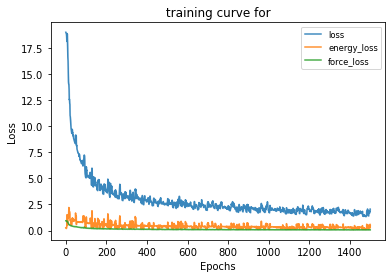

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.md.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[{"method": "set_range", "node_coordinates": "coords"}],
    model_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, force="forces", atomic_number="nuclear_charges", coordinates="coords")]
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17470.26782946]),
 'forces': array([[-2.722034  ,  2.670739  , -0.8522559 ],
        [-0.8815222 , -0.81415904,  1.9495636 ],
        [ 3.0880089 , -2.1758955 , -0.24201345],
        [-0.35358396,  1.67067   , -0.11213347],
        [-0.02528416,  1.8932064 ,  0.91162366],
        [-0.53088117,  0.17551896,  0.03228354],
        [ 0.30460304,  0.74183905, -2.111007  ],
        [-0.36753657, -1.331571  , -0.03520909],
        [ 0.49885795,  3.7871704 ,  1.9938719 ],
        [-0.70256585,  2.0608668 ,  0.7937086 ],
        [ 1.3156545 , -1.1790814 ,  0.3128655 ],
        [ 0.657438  , -3.7076998 , -1.8491228 ],
        [ 1.7086941 , -1.0903224 , -0.71348345],
        [-0.2634322 , -0.53486264,  0.42320517],
        [ 1.0613014 , -1.7537366 ,  1.2901518 ],
        [ 0.15603021,  0.21155357, -0.82895684],
        [-1.1747315 ,  0.4137119 , -0.1583417 ],
        [-0.49593544,  0.40450263, -0.08264048],
        [-0.3111951 , -1.1199214 , -0.75478107],
        [-0.44799328, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.md.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17470.26782925), 'forces': array([[-2.722033  ,  2.6707377 , -0.8522555 ],
       [-0.8815229 , -0.81415963,  1.9495641 ],
       [ 3.08801   , -2.1758947 , -0.24201386],
       [-0.35358438,  1.6706702 , -0.11213294],
       [-0.0252825 ,  1.8932062 ,  0.91162276],
       [-0.5308819 ,  0.17551982,  0.03228253],
       [ 0.30460367,  0.74183905, -2.1110077 ],
       [-0.36753637, -1.331571  , -0.03520826],
       [ 0.4988575 ,  3.7871704 ,  1.9938718 ],
       [-0.70256567,  2.060867  ,  0.7937086 ],
       [ 1.3156548 , -1.179083  ,  0.3128659 ],
       [ 0.65743726, -3.7076993 , -1.8491228 ],
       [ 1.7086935 , -1.0903219 , -0.7134833 ],
       [-0.2634322 , -0.5348626 ,  0.42320502],
       [ 1.0613004 , -1.7537367 ,  1.2901518 ],
       [ 0.15603004,  0.2115536 , -0.8289569 ],
       [-1.174732  ,  0.41371232, -0.1583416 ],
       [-0.49593538,  0.40450266, -0.08264035],
       [-0.31119496, -1.1199212 , -0.754781  ],
       [-0.44799313,  0.28776813, -0.487467

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.918eV  Ekin = 0.036eV (T=282K)  Etot = -831.881eV


Energy per atom: Epot = -831.941eV  Ekin = 0.060eV (T=467K)  Etot = -831.880eV
Energy per atom: Epot = -831.936eV  Ekin = 0.055eV (T=427K)  Etot = -831.881eV
Energy per atom: Epot = -831.927eV  Ekin = 0.048eV (T=371K)  Etot = -831.879eV
Energy per atom: Epot = -831.922eV  Ekin = 0.047eV (T=367K)  Etot = -831.875eV
Energy per atom: Epot = -831.928eV  Ekin = 0.053eV (T=407K)  Etot = -831.876eV
Energy per atom: Epot = -831.924eV  Ekin = 0.049eV (T=381K)  Etot = -831.875eV
Energy per atom: Epot = -831.926eV  Ekin = 0.051eV (T=397K)  Etot = -831.875eV
Energy per atom: Epot = -831.921eV  Ekin = 0.047eV (T=365K)  Etot = -831.873eV
Energy per atom: Epot = -831.927eV  Ekin = 0.052eV (T=405K)  Etot = -831.875eV
Energy per atom: Epot = -831.933eV  Ekin = 0.060eV (T=464K)  Etot = -831.873eV
Energy per atom: Epot = -831.914eV  Ekin = 0.041eV (T=316K)  Etot = -831.873eV
Energy per atom: Epot = -831.918eV  Ekin = 0.046eV (T=356K)  Etot = -831.872eV
Energy per atom: Epot = -831.917eV  Ekin = 0.045eV (